In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from my_nlp_module.preprocessing import preprocess_klej, PrepOption
from gensim.models import KeyedVectors
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import gc
from my_nlp_module.tokenizer import Tokenizer
from my_nlp_module.metrics import Metrics
import matplotlib.pyplot as plt

path_to_model = "../pretrained_models/62/model.bin"
model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
embed_dim = model.vector_size

2022-12-11 22:43:31.282645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_path = '../datasets/klej_ar/train.tsv'
dev_path = '../datasets/klej_ar/dev.tsv'

df_train = pd.read_csv(train_path, sep='\t')
df_train = df_train.sample(frac=1, axis=0).reset_index(drop=True)

df_test = pd.read_csv(dev_path, sep='\t')
df_test = df_test.sample(frac=1, axis=0).reset_index(drop=True)

# Poniżej należy odkomentować testowany zestaw wstępnego przetwarzania

options = [PrepOption.STOPWORDS, PrepOption.LOWERCASE, PrepOption.STEM,
           PrepOption.NUMBERS, PrepOption.RUBBISH, PrepOption.INTERPUNCTION]
#options = [PrepOption.NUMBERS, PrepOption.RUBBISH, PrepOption.INTERPUNCTION]

df_train = preprocess_klej(df_train, options, "../my_nlp_module/polish_stopwords.txt")
df_train['rating'] = df_train['rating'].apply(lambda x: x-1)

df_test = preprocess_klej(df_test, options, "../my_nlp_module/polish_stopwords.txt")
df_test['rating'] = df_test['rating'].apply(lambda x: x-1)

print(f"zbiór treningowy: {df_train.groupby(['rating'])['rating'].count()}")
print(f"zbiór testowy: {df_test.groupby(['rating'])['rating'].count()}")

Loading: 100%|██████████████| 11368252/11368252 [00:08<00:00, 1318631.97bytes/s]


zbiór treningowy: rating
0.0    1733
1.0    1069
2.0    1208
3.0    1644
4.0    3923
Name: rating, dtype: int64
zbiór testowy: rating
0.0    209
1.0    118
2.0    138
3.0    201
4.0    336
Name: rating, dtype: int64


In [3]:
MAX_WORDS = 8000
tok = Tokenizer(MAX_WORDS)
tok.fit(list(df_train['text']))
vocab_size = len(tok.vocab) + 1

embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.vocab.items():
    try:
        embed_vector=model[word]
        embed_matrix[i]=embed_vector
    except KeyError:
        continue

print(f"number of words {vocab_size}")

number of words 8001


In [4]:
encoded_train = tok.texts_to_sequences(list(df_train['text']))
encoded_test = tok.texts_to_sequences(list(df_test['text']))

lengths = []
m = -1
for doc in encoded_train:
    lengths.append(len(doc))
    if len(doc) > m:
        m = len(doc)
lengths = np.array(lengths)
mean = np.mean(lengths)
std = np.std(lengths)
max_doc_len = int(mean + std/2)
        
print(f"Maksymalna długość dokumentu: {max_doc_len}")
pad_docs_train = pad_sequences(encoded_train, maxlen=max_doc_len, padding='post')
pad_docs_test = pad_sequences(encoded_test, maxlen=max_doc_len, padding='post')

Maksymalna długość dokumentu: 80


In [5]:
x_train,x_validate,y_train,y_validate=train_test_split(pad_docs_train, np.array(df_train['rating']),
                                               test_size=0.20, random_state=42)

x_test = pad_docs_test
y_test = np.array(df_test['rating'])

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 200

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(f"train shape: {x_train.shape}\nvalidate shape: {x_validate.shape}\ntest shape: {x_test.shape}")

train shape: (7661, 80)
validate shape: (1916, 80)
test shape: (1002, 80)


2022-12-11 22:44:38.351235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
classifier=tf.keras.models.Sequential()

reg = tf.keras.regularizers.L2(l2=2)

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                      input_length=max_doc_len, weights=[embed_matrix],
                                      trainable=True, name="kodowanie_wyrazow")
classifier.add(embedding)

#classifier.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, kernel_regularizer=reg, dropout=0.1),
#                                             name="dwukierunkowe_LSTM"))
classifier.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60,dropout=0.1),
                                             name="dwukierunkowe_LSTM"))
classifier.add(tf.keras.layers.BatchNormalization(name="normalizacja_1"))

#classifier.add(tf.keras.layers.Dense(80, activation='sigmoid', kernel_regularizer=reg, name="warstwa_ukryta"))
classifier.add(tf.keras.layers.Dense(80, activation='sigmoid', name="warstwa_ukryta"))
classifier.add(tf.keras.layers.BatchNormalization(name="normalizacja_2"))
classifier.add(tf.keras.layers.Dropout(0.1))

classifier.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax, name='klasyfikator'))

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

epochs = 25

steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=init_lr,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)

optimizer1 = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule)

selected_optimizer = "adam"
optimizers = {
    "optimizer1": optimizer1,
    "adam": "adam",
    "sgd": "sgd"
}

classifier.compile(optimizer=optimizers[selected_optimizer],
                        loss=loss,
                        metrics=metrics)

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 kodowanie_wyrazow (Embeddin  (None, 80, 100)          800100    
 g)                                                              
                                                                 
 dwukierunkowe_LSTM (Bidirec  (None, 120)              77280     
 tional)                                                         
                                                                 
 normalizacja_1 (BatchNormal  (None, 120)              480       
 ization)                                                        
                                                                 
 warstwa_ukryta (Dense)      (None, 80)                9680      
                                                                 
 normalizacja_2 (BatchNormal  (None, 80)               320       
 ization)                                               

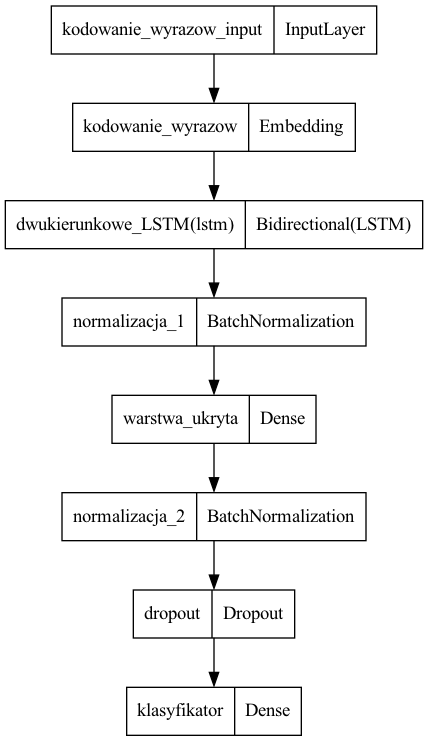

In [7]:
tf.keras.utils.plot_model(classifier)

In [8]:
del model
gc.collect()

checkpoint_filepath = './saved_model/pllstm'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                            min_delta=0.01, patience=5, mode='max')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)
history = classifier.fit(x_train,y_train,epochs=epochs,validation_data=(x_validate,y_validate),
                         callbacks=[early_stop, model_checkpoint_callback])
classifier.load_weights(checkpoint_filepath)

Epoch 1/25
240/240 [==============================] - 14s 45ms/step - loss: 1.4393 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.3094 - val_sparse_categorical_accuracy: 0.5282
Epoch 2/25
240/240 [==============================] - 10s 42ms/step - loss: 1.1002 - sparse_categorical_accuracy: 0.5631 - val_loss: 1.1482 - val_sparse_categorical_accuracy: 0.5376
Epoch 3/25
240/240 [==============================] - 10s 42ms/step - loss: 0.9233 - sparse_categorical_accuracy: 0.6289 - val_loss: 1.2756 - val_sparse_categorical_accuracy: 0.5219
Epoch 4/25
240/240 [==============================] - 10s 42ms/step - loss: 0.7623 - sparse_categorical_accuracy: 0.7076 - val_loss: 1.8064 - val_sparse_categorical_accuracy: 0.4421
Epoch 5/25
240/240 [==============================] - 10s 42ms/step - loss: 0.5858 - sparse_categorical_accuracy: 0.7782 - val_loss: 1.6808 - val_sparse_categorical_accuracy: 0.4509
Epoch 6/25
240/240 [==============================] - 10s 42ms/step - loss: 0.4517 - spars

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


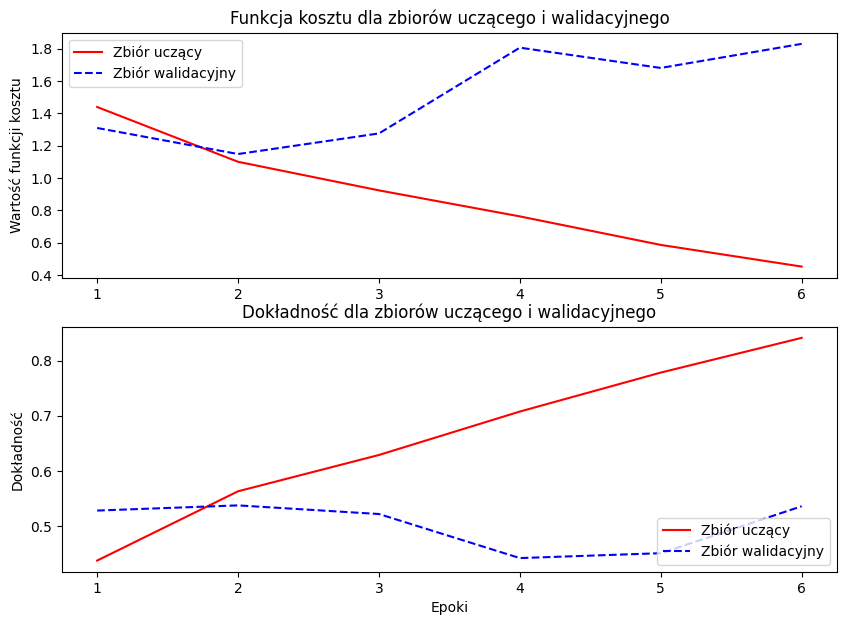

In [9]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 7))
fig.tight_layout(pad=10)

plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_loss, '--b', label='Zbiór walidacyjny')
plt.title('Funkcja kosztu dla zbiorów uczącego i walidacyjnego')
plt.ylabel('Wartość funkcji kosztu')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, 'r', label='Zbiór uczący')
plt.plot(epochs_range, val_acc, '--b', label='Zbiór walidacyjny')
plt.title('Dokładność dla zbiorów uczącego i walidacyjnego')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')

In [10]:
"""encoded_test = tok.texts_to_sequences(list(df_test["text"]))
for i, enc in enumerate(encoded_test):
    if len(enc) < max_doc_len:
        encoded_test[i] = pad_sequences([enc], maxlen=max_doc_len, padding='post')[0]
    elif len(enc) > max_doc_len:
        encoded_test[i] = encoded_test[i][:max_doc_len]
encoded_test = np.array(encoded_test)"""

def predict_function(model, x):
    result = []
    outputs = model.predict(x, verbose=0)
    for out in outputs:
        class_number = int(tf.math.argmax(out))
        result.append(class_number)
    return np.array(result)

metrics = Metrics(classifier, predict_function)
print("Metryki dla zbioru testowego")
_ = metrics.accuracy(x_test, y_test)
_ = metrics.precision(x_test, y_test)
_ = metrics.recall(x_test, y_test)
_ = metrics.f1(x_test, y_test)

metrics.print_confusion_matrix(x_test, y_test)
metrics.print_metrics(x_test, y_test)

Metryki dla zbioru testowego
Dokładność: 0.49600798403193613
Precyzja: [0.43896104 0.23584906 0.4        0.40163934 0.65625   ]
Czułość: [0.80861244 0.21186441 0.01449275 0.24378109 0.75      ]
F1: [0.56902357 0.22321429 0.02797203 0.30340557 0.7       ]
[[169  20   2   5  13]
 [ 76  25   0  13   4]
 [ 58  28   2  28  22]
 [ 40  19   0  49  93]
 [ 42  14   1  27 252]]
╒═══════╤═══════╤═══════╤═══════╤═══════╕
│ 0.439 │ 0.236 │ 0.4   │ 0.402 │ 0.656 │
├───────┼───────┼───────┼───────┼───────┤
│ 0.809 │ 0.212 │ 0.014 │ 0.244 │ 0.75  │
├───────┼───────┼───────┼───────┼───────┤
│ 0.569 │ 0.223 │ 0.028 │ 0.303 │ 0.7   │
╘═══════╧═══════╧═══════╧═══════╧═══════╛
Dokładność: 0.496


In [11]:
print(f"Max words: {MAX_WORDS}\n\n\nParametry modelu:\nwstępne przetwarzanie: {options}\nilość epok: {epochs}\nalgorytm optymalizacyjny: {selected_optimizer}")

Max words: 8000


Parametry modelu:
wstępne przetwarzanie: [<PrepOption.NUMBERS: 7>, <PrepOption.RUBBISH: 6>, <PrepOption.INTERPUNCTION: 4>]
ilość epok: 25
algorytm optymalizacyjny: adam
